##### source of references: 

https://medium.com/analytics-vidhya/face-recognition-with-vgg-face-in-keras-96e6bc1951d5
(and a few github pages)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
data = np.load(r"C:\Users\Vishak\Great Learning\Computer Vision\Computer Vision Project 2\Part 1- Train data - images.npy", allow_pickle = True)

In [4]:
data[0][1]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}],
  'imageWidth': 650,
  'imageHeight': 333},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}],
  'imageWidth': 650,
  'imageHeight': 333}]

In [3]:
train_data, val_data = train_test_split(data, test_size = 0.25, random_state = 1 )

In [4]:
print(train_data.shape, val_data.shape) 

(306, 2) (103, 2)


* In the dimensions given above, in each, the first value denotes the number of samples and the second denotes the information corresponding to each sample. 

* This information consists of the image array and the information for bounding boxes. 

#### setting parameters

In [5]:
ALPHA = 1 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower
          # choose the number according to how much of the mobilenet you need. 

im_size = 224

###### Below we'll be able to see that each training example consists of the image array and the related data required for bounding box construction. 

In [6]:
# img, meta = train_data[1]

In [7]:
# for i in train_data:
#     img, meta = train_data[i]
#     for j in range((len(meta))):
#         _,_,coords, im_w, im_h = meta[j].values()
#         tl,br = coords
#         x0, y0 = tl
#         x1, y1 = br

From hindsight, it should be pretty useful to check for images without a third dimension for the process can get clunky later on due to non uniform image dimensions. 

In [8]:
j = 0
for i,d in enumerate(data):
    img, meta = d
    try:
        a = [np.zeros((img.shape[0],img.shape[1],3)), np.zeros((img.shape[0],img.shape[1],3)), img]
        a = np.array(a)
    except:
        if(len(img.shape) < 3):
                print(i,img.shape)
        continue
        
    

c:\users\vishak\anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


272 (350, 650)


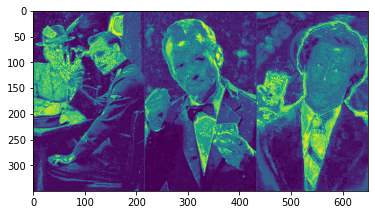

In [83]:
plt.imshow(data[272][0])

In [24]:
data[0][1][0]

{'label': ['Face'],
 'notes': '',
 'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
  {'x': 0.1723076923076923, 'y': 0.45345345345345345}],
 'imageWidth': 650,
 'imageHeight': 333}

In [40]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), im_size, im_size))
X_train = np.zeros((int(data.shape[0]), im_size, im_size, 3))
for index in range(data.shape[0]):
                                img = data[index][0]
                                img = cv2.resize(img, dsize=(im_size, im_size), interpolation=cv2.INTER_CUBIC)
                                try:
                                  img = img[:, :, :3]
                                except:
                                  continue
                                X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
                                for i in data[index][1]:
                                    x1 = int(i["points"][0]['x'] * im_size)
                                    x2 = int(i["points"][1]['x'] * im_size)
                                    y1 = int(i["points"][0]['y'] * im_size)
                                    y2 = int(i["points"][1]['y'] * im_size)
                                    masks[index][y1:y2, x1:x2] = 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


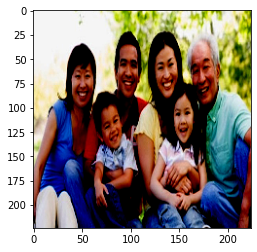

In [48]:
plt.imshow(X_train[4])

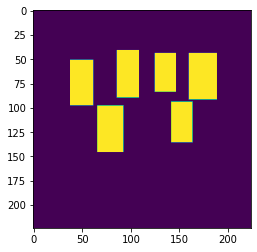

In [49]:
plt.imshow(masks[4])

<!--         x0,y0 = 100*x0,96*y0
         x1,y1 = 96*x1,96*y1
 try:
 except:
             continue -->

#### MODEL CONSTRUCTION

In [50]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model

In [48]:
# from tensorflow.keras.applications.mobilenet import MobileNet
# from tensorflow.keras.layers import Concatenate, Conv2D, Reshape, UpSampling2D
# from tensorflow.keras.models import Model

# def create_model(trainable=True):
#     model = MobileNet(input_shape=(im_size, im_size, 3), include_top=False, alpha=ALPHA, weights="imagenet")

#     for layer in model.layers:
#         layer.trainable = trainable

#     block1 = model.get_layer("conv_pw_5_relu").output #layer 5 this layer will be bigger since it's either less pooled or unpooled. 
#     block2 = model.get_layer("conv_pw_11_relu").output #layer 11 this layer will be smaller due to the pooling
#     block3 = model.get_layer("conv_pw_13_relu").output #layer 13 this layer will be the smallest due to the pooling

#     x = Concatenate()([UpSampling2D()(block3), block2]) #upsample block 3 to level of block2 and concatenate with block 2
#     x = Concatenate()([UpSampling2D()(x), block1]) #upsample block2 to level of block 1 and concatenate with block 1

#     x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
#     x = Reshape((28, 28))(x)

#     return Model(inputs=model.input, outputs=x)

###### For some weird reason the input name keeps changing for every call and hence after a few guesses and attempts 'input_9' turned out to be the right one. 

In [51]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model


def create_model(trainable=True):
     #### code added below ####
    model = MobileNet(input_shape=(im_size,im_size, 3), include_top=False, alpha=1.0, weights="imagenet")
    
    for layer in model.layers:
        layer.trainable = trainable

    # Add all the UNET layers here
    #### code added below ####

    # Since mask size is 224 (same as input), we need to concatenate it back all 6 layers, i.e layers of sizes 7,14,28,56,112 & 224, bottom onwards
    block1 = model.get_layer("input_1").output         #224
    block2 = model.get_layer("conv_pw_1_relu").output  #112
    block3 = model.get_layer("conv_pw_3_relu").output  #56
    block4 = model.get_layer("conv_pw_5_relu").output  #28
    block5 = model.get_layer("conv_pw_11_relu").output #14
    block6 = model.get_layer("conv_pw_13_relu").output #7

    x = Concatenate()([UpSampling2D()(block6), block5])
    x = Concatenate()([UpSampling2D()(x), block4])
    x = Concatenate()([UpSampling2D()(x), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
 
    # Add new top layer which is an sigmoid activation layer that gives 1 or 0 depending on inside/outside the face
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((im_size,im_size))(x)
 
    return Model(inputs=model.input, outputs=x)

   

##### DEFINING DICE COEFFICIENT

In [72]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

##### DEFINING LOSS

In [73]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.keras.backend.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

##### MODEL CREATION

In [54]:
model = create_model(True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
______________________________________________________________________________________________

##### COMPILING THE MODEL

In [55]:
import tensorflow as tf

In [64]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=1e-20, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

##### DEFINING CALL BACKS

In [65]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor="loss", patience=5)

reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)

###### FITTING THE MODEL

In [66]:
model.fit(X_train, masks,callbacks=[checkpoint, reduce_lr, stop], epochs=30, batch_size=1,use_multiprocessing=True,verbose=1)

Train on 409 samples
Epoch 1/30
408/409 [============================>.] - ETA: 0s - loss: 0.6602 - dice_coefficient: 0.6537
Epoch 00001: loss improved from inf to 0.66039, saving model to model-0.66.h5
409/409 [==============================] - 50s 123ms/sample - loss: 0.6604 - dice_coefficient: 0.6534
Epoch 2/30
408/409 [============================>.] - ETA: 0s - loss: 0.6360 - dice_coefficient: 0.6646
Epoch 00002: loss improved from 0.66039 to 0.63555, saving model to model-0.64.h5
409/409 [==============================] - 44s 108ms/sample - loss: 0.6356 - dice_coefficient: 0.6649
Epoch 3/30
408/409 [============================>.] - ETA: 0s - loss: 0.6079 - dice_coefficient: 0.6756
Epoch 00003: loss improved from 0.63555 to 0.60797, saving model to model-0.61.h5
409/409 [==============================] - 44s 108ms/sample - loss: 0.6080 - dice_coefficient: 0.6758
Epoch 4/30
408/409 [============================>.] - ETA: 0s - loss: 0.5786 - dice_coefficient: 0.6897
Epoch 00004: lo

Epoch 29/30
408/409 [============================>.] - ETA: 0s - loss: 0.3897 - dice_coefficient: 0.7798
Epoch 00029: loss improved from 0.39135 to 0.38948, saving model to model-0.39.h5
409/409 [==============================] - 44s 108ms/sample - loss: 0.3895 - dice_coefficient: 0.7799
Epoch 30/30
408/409 [============================>.] - ETA: 0s - loss: 0.3869 - dice_coefficient: 0.7813
Epoch 00030: loss improved from 0.38948 to 0.38696, saving model to model-0.39.h5
409/409 [==============================] - 44s 108ms/sample - loss: 0.3870 - dice_coefficient: 0.7810


In [67]:
model.save('fd.h5')
model.save_weights('fd_weights.h5')

In [78]:
def create_model(trainable=True):
    model = MobileNet(input_shape=(im_size,im_size, 3), include_top=False, alpha=1.0, weights="imagenet")
    
    for layer in model.layers:
        layer.trainable = trainable

    
    block1 = model.get_layer("input_5").output         #224
    block2 = model.get_layer("conv_pw_1_relu").output  #112
    block3 = model.get_layer("conv_pw_3_relu").output  #56
    block4 = model.get_layer("conv_pw_5_relu").output  #28
    block5 = model.get_layer("conv_pw_11_relu").output #14
    block6 = model.get_layer("conv_pw_13_relu").output #7

    x = Concatenate()([UpSampling2D()(block6), block5])
    x = Concatenate()([UpSampling2D()(x), block4])
    x = Concatenate()([UpSampling2D()(x), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
 
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((im_size,im_size))(x)
 
    return Model(inputs=model.input, outputs=x)

In [79]:
WEIGHTS_FILE = "model-0.95.h5"
THRESHOLD = 0.8
EPSILON = 0.02

model = create_model()
model.load_weights(WEIGHTS_FILE)

In [80]:
eg_img = X_train[4]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


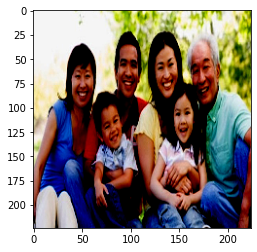

In [81]:
plt.imshow(eg_img)

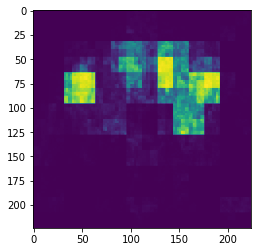

In [85]:
pred = model.predict(eg_img.reshape(1,224,224,3))
plt.imshow(pred.reshape(224,224))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


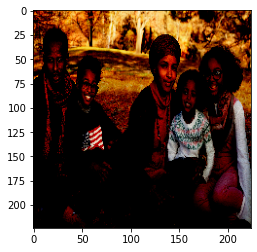

In [86]:
eg_img = X_train[12]
plt.imshow(eg_img)

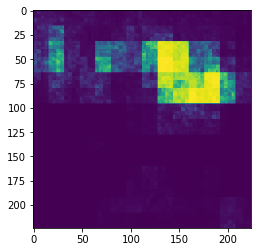

In [87]:
pred = model.predict(eg_img.reshape(1,224,224,3))
plt.imshow(pred.reshape(224,224))

In [88]:
masks[4]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [110]:
test_img = cv2.imread(r"C:\Users\Vishak\Great Learning\Computer Vision\Computer Vision Project 2\Part 1Test Data - Prediction Image.jpeg")
test_img = cv2.resize(test_img, (224,224),interpolation=cv2.INTER_CUBIC)
test_img = test_img[:,:,:3]
test_img = preprocess_input(np.array(test_img, dtype=np.float32))

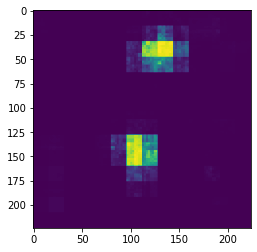

In [111]:
test_pred = model.predict(test_img.reshape(1,224,224,3))
plt.imshow(test_pred.reshape(224,224))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


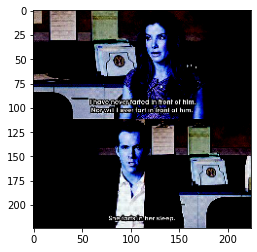

In [112]:
plt.imshow(test_img)

### PART 2

In [1]:
path = r"C:\Users\Vishak\Great Learning\Computer Vision\Computer Vision Project 2\PINS"

###### loading the images

In [2]:
import numpy as np
import os

In [3]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        self.base = base
        self.name = name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f)) #this is basically a template containing specific path fragments. 
    return np.array(metadata)


metadata = load_metadata('PINS')

In [4]:
metadata

array([PINS\pins_Aaron Paul\Aaron Paul0_262.jpg,
       PINS\pins_Aaron Paul\Aaron Paul101_247.jpg,
       PINS\pins_Aaron Paul\Aaron Paul101_248.jpg, ...,
       PINS\pins_zendaya\zendaya97.jpg, PINS\pins_zendaya\zendaya98.jpg,
       PINS\pins_zendaya\zendaya99.jpg], dtype=object)

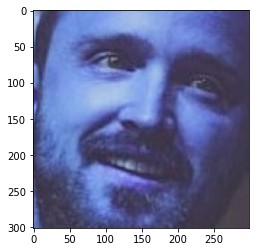

In [5]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread(metadata[0].image_path())
plt.imshow(img[:,:,:3])

In [6]:
img.shape

(301, 299, 3)

###### VGG face model

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

###### loading the weights

In [8]:
model = vgg_face()
WEIGHTS_FILE = "vgg_face_weights.h5"
model.load_weights(WEIGHTS_FILE)

###### Defining the model input and output

In [9]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

It has to be noted that output/embeddings is of the size 2622. 
###### Therefore while allocating space for appending the embedding, this will be the feature size. 

In [11]:
embds = np.zeros((metadata.shape[0], 2622))

In [12]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [13]:
embds = np.zeros((metadata.shape[0], 2622))
for i, d in enumerate(metadata):
                                 try:
                                        image = load_image(d.image_path())                                        
                                        image = (image / 255.).astype(np.float32) # Normalisation
                                        image = cv2.resize(image, dsize = (224,224))
                                        embds[i] = vgg_face_descriptor.predict(np.expand_dims(image, axis=0))[0]
                                 except:
                                    pass


###### defining the distance metric

L2 distance is the sum of square of the distance between two points. 

In [14]:
def l2_dist(x1, x2):
    return np.sum(np.square(x1 - x2))

##### checking the distance between two images

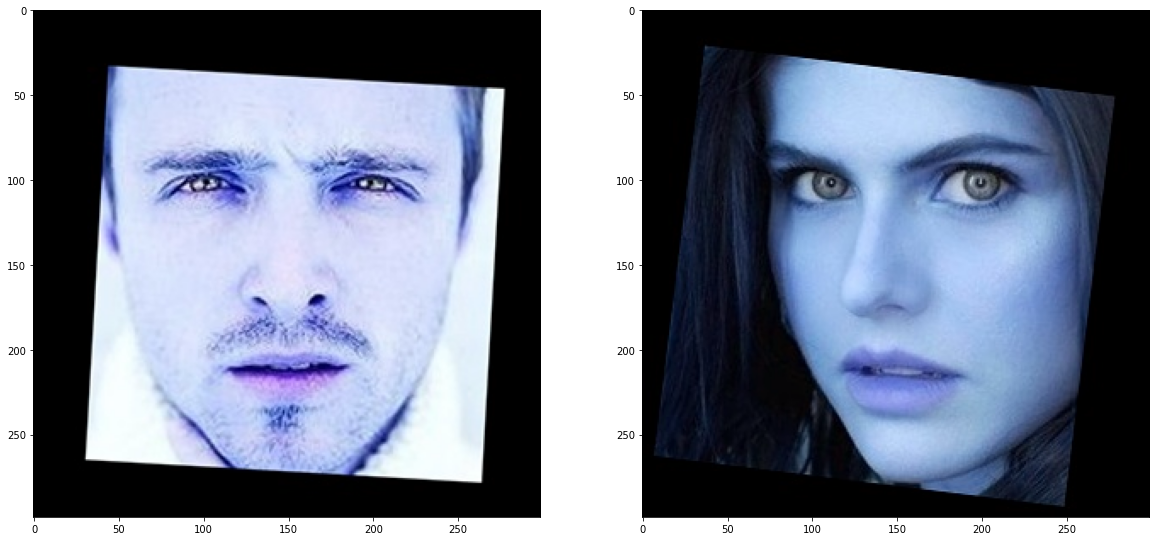

In [15]:
im1 = cv2.imread(metadata[1].image_path())
im2 = cv2.imread(metadata[86].image_path())
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(im1)
plt.subplot(1,2,2)
plt.imshow(im2)

In [16]:
print(l2_dist(embds[1],embds[86]))

0.8506902499651375


In [17]:
print(l2_dist(embds[1],embds[1]))

0.0


###### hence it can be observed from the l2 distance calculation between two different images and the exact same images are vast and nil resepectively. 

In [18]:
from sklearn.model_selection import train_test_split
tr_id, tes_id = train_test_split(np.arange(metadata.shape[0]), test_size = 0.15, random_state = 1)

splitting the indexes into train and test to split the data based on the resulting boolean mask. 

In [101]:
x_train = embds[tr_id]
x_test = embds[tes_id]

###### below is the exact split ratio. 

In [20]:
x_test.shape[0]/x_train.shape[0]

0.17653484815381254

In [21]:
from sklearn.preprocessing import LabelEncoder

classes = [i.name.replace('pins_','') for i in metadata]
classes = np.array(classes)

In [22]:
le = LabelEncoder()
le.fit(classes)
classes = le.transform(classes)

In [23]:
y_train = classes[tr_id]
y_test = classes[tes_id]

###### principal component analysis

In [24]:
from sklearn.decomposition import PCA 

In [25]:
from sklearn.preprocessing import StandardScaler

scl_tr = StandardScaler()
embds_sc = scl_tr.fit_transform(embds)

In [26]:
embds.shape[1]

2622

In [27]:
pca = PCA(n_components=2622)
pca.fit(embds_sc)

PCA(n_components=2622)

In [28]:
print(pca.explained_variance_)

[3.56063841e+02 1.41154574e+02 1.04195362e+02 ... 4.65947897e-06
 4.53170509e-06 2.54701526e-07]


In [29]:
print(pca.components_)

[[-2.38816939e-02  8.85343731e-03 -3.12211372e-03 ... -8.22362097e-03
   2.13278686e-02  3.88700730e-02]
 [ 2.07324385e-02 -1.00079706e-03  8.45987806e-03 ... -2.31986081e-02
  -4.18977512e-03  1.10628565e-02]
 [ 2.39080119e-03  1.86762037e-03 -7.06642112e-03 ...  1.09491250e-02
  -8.90396779e-04 -1.60735110e-02]
 ...
 [ 9.94366146e-04 -5.15323473e-04 -9.14287231e-04 ...  1.90726705e-03
   7.24063444e-04  1.25614197e-03]
 [ 6.84951172e-05 -1.13998744e-03  5.23265178e-04 ... -8.15598791e-04
   7.78602986e-04  6.19106351e-05]
 [ 1.70445535e-02  2.10056850e-02  1.86590997e-02 ...  1.93349557e-02
   1.90640110e-02  2.31081307e-02]]


In [30]:
print(pca.explained_variance_ratio_)

[1.35785957e-01 5.38296977e-02 3.97351973e-02 ... 1.77690554e-09
 1.72817861e-09 9.71311507e-11]


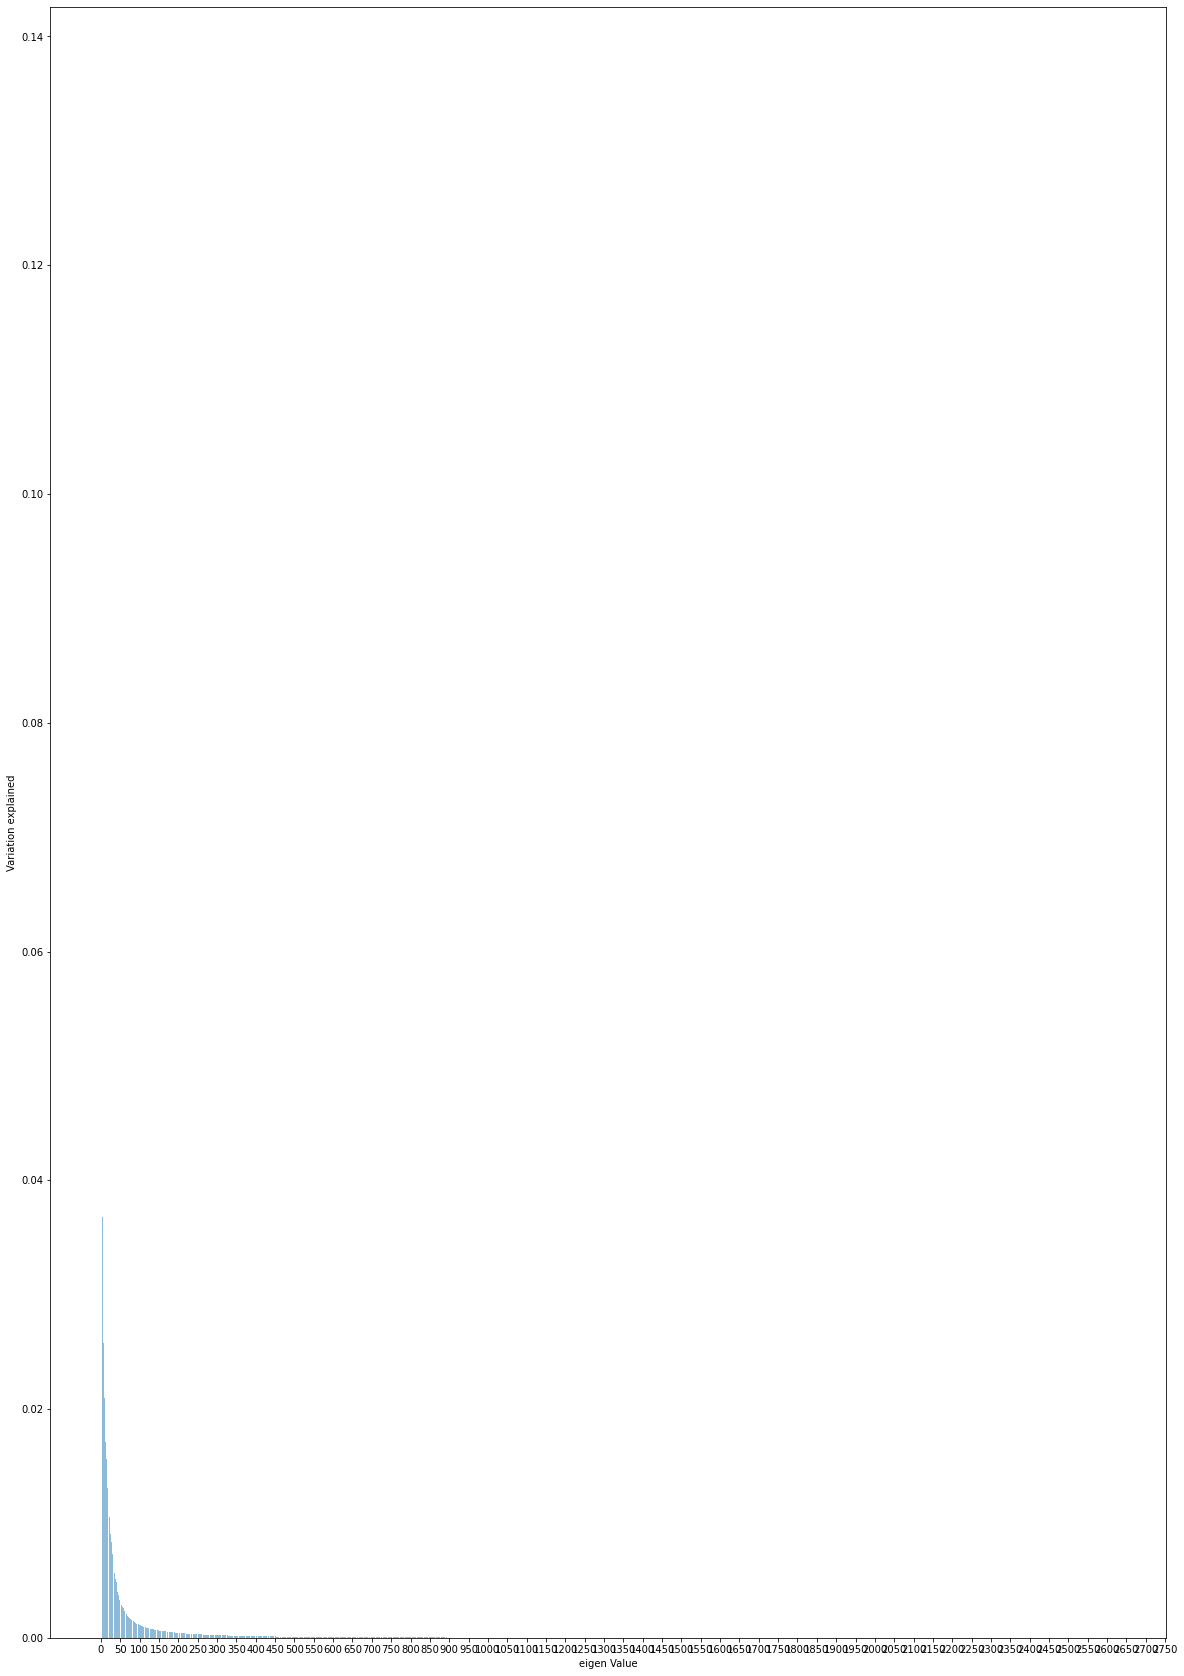

In [31]:
plt.figure(figsize = (20,30))
plt.bar(list(range(1,2623)),pca.explained_variance_ratio_,alpha=0.5, align='center')
plt.xticks(np.arange(0, 2800, 50))
plt.ylabel('Variation explained')
plt.xlabel('eigen Value')
plt.show()

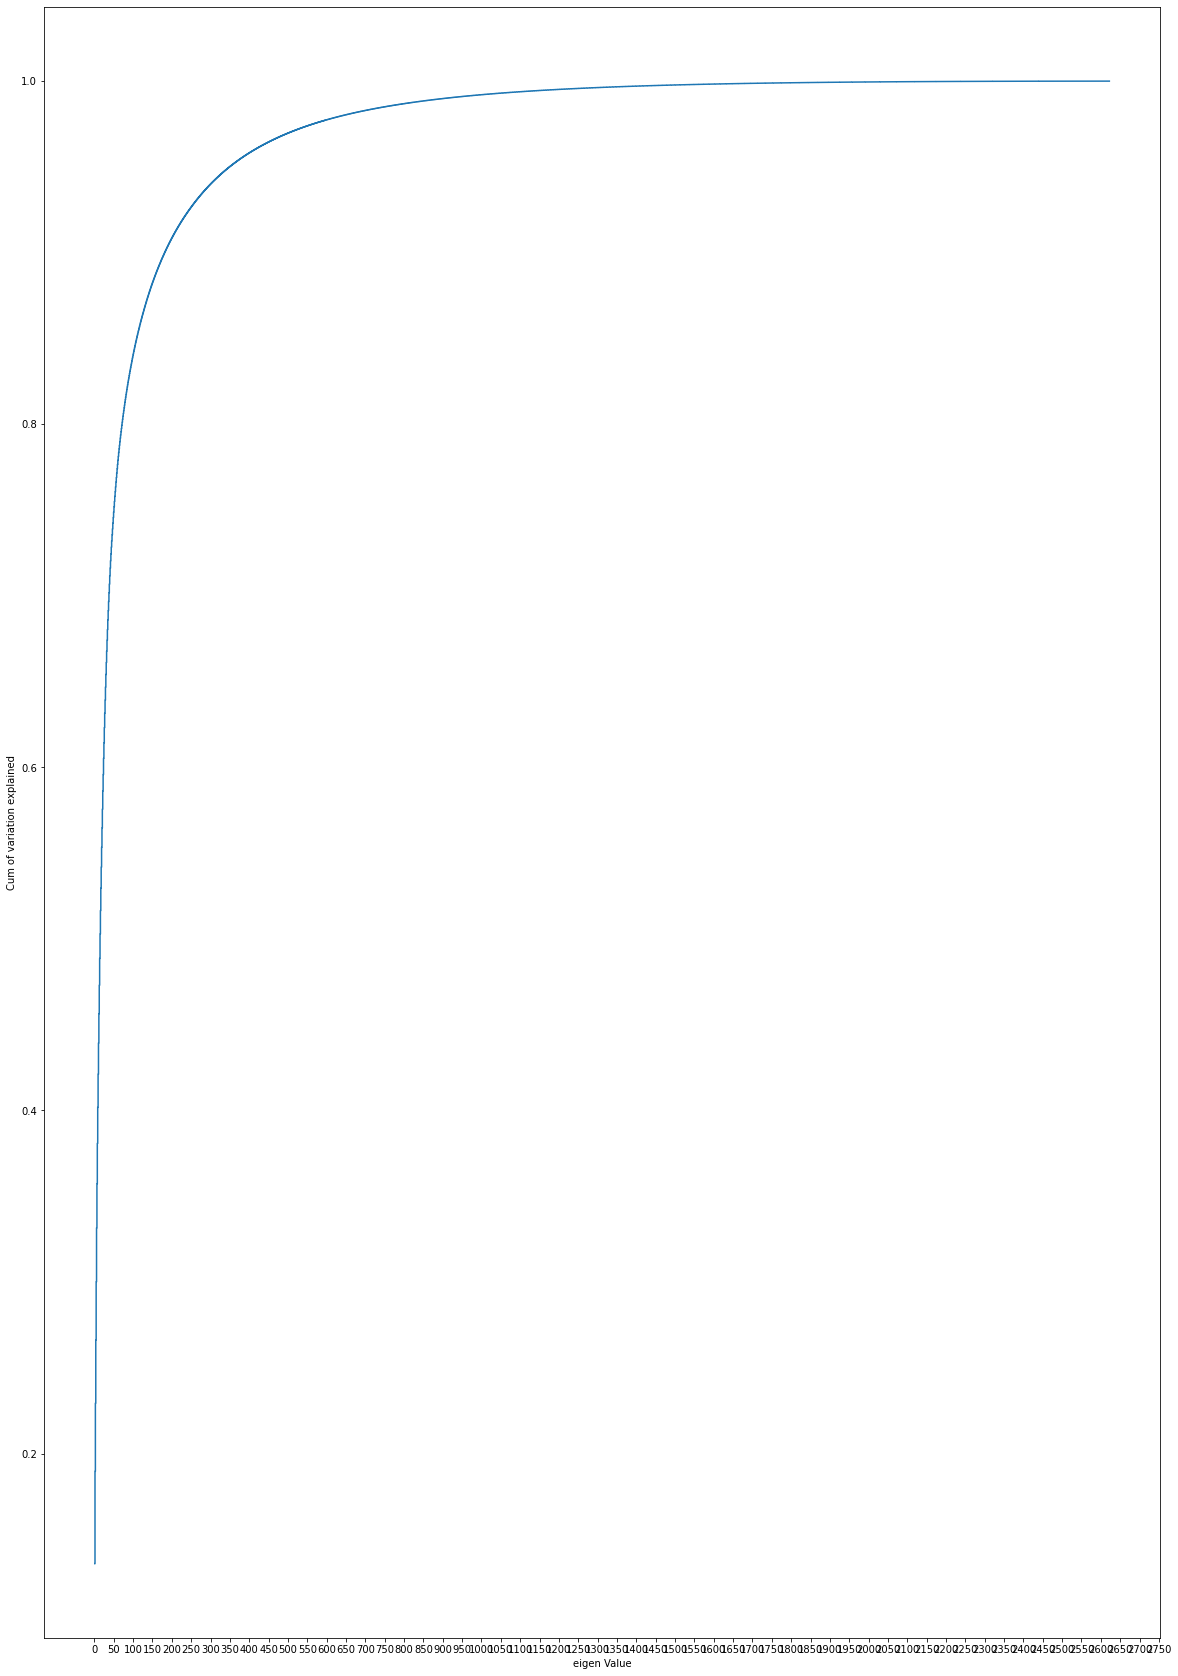

In [32]:
plt.figure(figsize = (20,30))
plt.step(list(range(1,2623)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.xticks(np.arange(0, 2800, 50))
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

###### It appears we can explain upto 95% data with 610 features. 

In [102]:
from sklearn.preprocessing import StandardScaler

scl_tr = StandardScaler()
scl_tes = StandardScaler()
x_train = scl_tr.fit_transform(x_train)
x_test = scl_tes.fit_transform(x_test)

In [34]:
pca = PCA(n_components=615)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.fit_transform(x_test)

###### Several different iterations with different hyperparameter configuration can be observed below. 

In [35]:
from sklearn import svm
clf = svm.SVC(gamma=0.025, C=3)    

In [36]:
clf.fit(x_train_pca, y_train)

SVC(C=3, gamma=0.025)

In [37]:
from sklearn.metrics import accuracy_score

pred = clf.predict(x_test_pca)
score = accuracy_score(y_test, pred)

In [38]:
score

0.019183168316831683

In [39]:
from sklearn import svm
clf = svm.SVC(gamma=0.0025, C=30) 
clf.fit(x_train_pca, y_train)
pred = clf.predict(x_test_pca)
score = accuracy_score(y_test, pred)
score

0.03527227722772277

In [40]:
from sklearn import svm
clf = svm.SVC(gamma=0.00025, C=300) 
clf.fit(x_train_pca, y_train)
pred = clf.predict(x_test_pca)
score = accuracy_score(y_test, pred)
score

0.2110148514851485

In [41]:
from sklearn import svm
clf = svm.SVC(gamma=0.000025, C=3000) 
clf.fit(x_train_pca, y_train)
pred = clf.predict(x_test_pca)
score = accuracy_score(y_test, pred)
score

0.20482673267326731

In [42]:
from sklearn import svm
clf = svm.SVC(gamma=0.00015, C=2500) 
clf.fit(x_train_pca, y_train)
pred = clf.predict(x_test_pca)
score = accuracy_score(y_test, pred)
score

0.2103960396039604

In [43]:
scores = []
cs = []
for c in range(300,2500,100):
        clf = svm.SVC(gamma=0.00015, C=c) 
        clf.fit(x_train_pca, y_train)
        pred = clf.predict(x_test_pca)
        score = accuracy_score(y_test, pred)
        cs.append(c)
        scores.append(score)

In [44]:
scores

[0.2103960396039604,
 0.2103960396039604,
 0.2103960396039604,
 0.2103960396039604,
 0.2103960396039604,
 0.2103960396039604,
 0.2103960396039604,
 0.2103960396039604,
 0.2103960396039604,
 0.2103960396039604,
 0.2103960396039604,
 0.2103960396039604,
 0.2103960396039604,
 0.2103960396039604,
 0.2103960396039604,
 0.2103960396039604,
 0.2103960396039604,
 0.2103960396039604,
 0.2103960396039604,
 0.2103960396039604,
 0.2103960396039604,
 0.2103960396039604]

Hence it is clear that there's no scope for accuracy improvement regardless of any unique configuration. The reason is most probably that some or a lot of the key defining features are lost into dimensionality reduction and hence predictive factor becomes weak. 

###### Below attempts with models trained on regular scaled embeddings will be observed. 

In [45]:
clf = svm.SVC(gamma=0.00015, C=2500) 
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
score = accuracy_score(y_test, pred)
score

0.9603960396039604

In [109]:
clf = svm.SVC(gamma=0.0001, C=4000) 
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
score = accuracy_score(y_test, pred)
score

0.9616336633663366

In [73]:
test_img1 = cv2.imread(r"C:\Users\Vishak\Great Learning\Computer Vision\Computer Vision Project 2\Part 2 Test Images\Part_2_-_Test_Image_-_Dwayne_Johnson4.jpg")
test_img2 = cv2.imread(r"C:\Users\Vishak\Great Learning\Computer Vision\Computer Vision Project 2\Part 2 Test Images\Part_2-_Test_Image_-_Benedict_Cumberbatch9.jpg")

In [74]:
test_img1 = test_img1[...,::-1]
test_img2 = test_img2[...,::-1]

In [75]:
test_embd = []
for image in [test_img1, test_img2]:
    image = (image / 255.).astype(np.float32) # Normalisation
    image = cv2.resize(image, dsize = (224,224))
    image = vgg_face_descriptor.predict(np.expand_dims(image, axis=0))[0]
    test_embd.append(image)

In [100]:
test_embd = scl_tr.fit_transform(test_embd)

In [121]:
le.classes_[clf.predict(test_embd[0].reshape(1,test_embd.shape[1]))[0]]

'Dwayne Johnson'

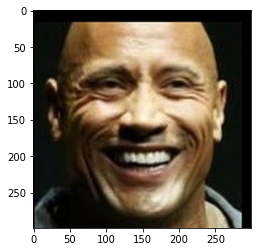

In [116]:
plt.imshow(test_img1)

In [120]:
le.classes_[clf.predict(test_embd[1].reshape(1,test_embd.shape[1]))[0]]

'Benedict Cumberbatch'

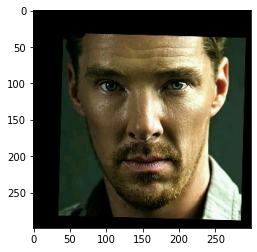

In [122]:
plt.imshow(test_img2)

###### Hence a significant result could be achieved well without pca implementation but with the use of image embeddings. 